In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

np.set_printoptions(legacy='1.25')

#### Custom numerical integration

In [4]:
def compositie_simpson(ys, xmin, xmax):
    """
    Implementation of Simpson's method to solve 1-dimensional integrals
    """
    # Requirement: Number of interals is odd
    N = len(ys) - 1

    if N % 2 == 0:
        print("Number of steps must be odd and (N-1)/2 must be even")
        sys.exit()
    
    dx = (xmax - xmin) / N

    area = ys[0] + ys[-1] + sum([2 * ys[n] if n % 2 == 0 else 4 * ys[n] for n in range(1,N)])

    return (dx / 3.0) * area


def integrate(ys, xmin, xmax) -> tuple:
    
    S1 = compositie_simpson(ys, xmin, xmax)
    S2 = compositie_simpson(ys[0::2], xmin, xmax)

    #error = abs(S1 - S2) / 15

    return S1

#### Numerical Methods

In [5]:
def euler_method(f, h, rhs_func):
    
    f_new = f + h * rhs_func

    return f_new


def trapezoid_method(f, h, rhs_func, rhs_func_new):

    f_new = f + 0.5 * h * (rhs_func + rhs_func_new)

    return f_new

#### Boltzmann integrands and integrals

In [6]:
def eps(x,y):
    """
    Dimensionless energy (Energy/Temperature)
    """
    return np.sqrt(x*x + y*y)


def F1(x,y1, y2, f_y1, f_y2):
    
    return -f_y1 * f_y2 + np.exp(-eps(x,y1) - eps(x,y2))


def F2(x,y1, y2, f_y1, f_y2):
    
    return -f_y1 + f_y2 * np.exp(-eps(x,y1)-eps(x,y2))

def I(x, y1, y2, f_y1, f_y2):
    G = 1 
    return G * G / 2 * F1(x, y1, y2, f_y1, f_y2)

def H(x, y1, y3, f_y1, f_y3):
    G = 1
    return G * G * 2 /(y1 * y3) * (np.exp(- abs(y1 - y3)/2) - np.exp(-(y1 + y3)/2)) * F2(x, y1, y3, f_y1, f_y3)



def C_ann(x:float, y1:float, y2s:list, f_y1:float, f_y2s:list) -> float:
    """
    Dimensionless Annihilation Operator - integrand
    """
    # define the integrand
    integrand = lambda x, y1, y2, f_y1, f_y2: y2 * y2 /(4 * eps(x,y1) * eps(x, y2)) * I(x, y1, y2, f_y1, f_y2) * F1(x, y1, y2, f_y1, f_y2)

    # compute the integrand for different y3-values
    Fs = [integrand(x,y1,y2,f_y1,f_y2) for y2, f_y2 in zip(y2s, f_y2s)]


    return 1 / (2*np.pi)**3 * integrate(Fs,y2s[0],y2s[-1])



def C_scatter(x:float, y1:float, y3s:list,f_y1:float,f_y3s:list) -> float:
    """
    Dimensionless Scattering Operator
    """
    # define the integrand
    integrand = lambda x, y1, y3, f_y1, f_y3: y3 * y3 / (4 * eps(x, y1) * eps(x, y3)) * H(x, y1, y3, f_y1, f_y3) * F2(x, y1, y3, f_y1, f_y3)

    # compute the integrand for different y3-values
    Fs = [integrand(x,y1,y3,f_y1,f_y3) for y3, f_y3 in zip(y3s, f_y3s)]    

    return 1 / (2 * np.pi)**3 * integrate(Fs,y3s[0],y3s[-1])

#### Integro-Partiel-Differential-Equation Computational Solver
In this section of the code we solve the dimensionless Boltzmann equation that looks like
$$
f(y,x+\Delta x) = f(y,x) + \Delta x  \cdot \frac{1}{x\cdot H(x)}\left(y \cdot df\_dy + \sum \hat{C}(x,y)\right)
$$

In [14]:
def IntegroPartialDifferentialEquationSolver(xmin:float, xmax:float,ys:list,initial_condition) -> list:
    """
    Function that solves the BE for the distribution function given
    the starting and ending point of (dimensionless) time and the
    collision operators for the interaction and a list of momentum
    values. 


    xmin                -> float                :   Takes the smallest x-value 
    xmax                -> float                :   Takes the largest x-value
    ys                  -> list                 :   List of all dimensionless momentum values
    initial_condition   -> function (-> float)  :   initial values that computes f at x0
    collisions          -> function (-> float)  :   Computes the collision integrals

    """

    fs =  [[initial_condition(y,xmin)] for y in ys]             # Initial distribution function matrix
    xs = []                                                     # Time steps

    N = len(ys) # # momentum values
    dx = 0.001   # small time increment
    

    x = xmin    # Initial value of x
    i = 0       # iteration

    while (x < xmax):
        for j in range(N):

           
            # Compute the derivative w.r.t. y      
            if j == 0:
                df_dy = 0
            elif (j == N-1):
                df_dy = (fs[j][i] - fs[j-1][i]) / (ys[j]-ys[j-1])
            else:
                df_dy = (fs[j+1][i] - fs[j][i]) / (ys[j+1] - ys[j])

            f_ys = [fs[k][i] for k in range(N)]

            df_dy = 0

            # compute the annihilation and scattering integrals
            ann = C_ann(x,ys[j],ys,fs[j][i],f_ys)
            sca = C_scatter(x,ys[j],ys,fs[j][i],f_ys)

            # Compute the right-hand side
            c = 1
            y = ys[j]
            
            
            rhs_func = 1/x * (y * df_dy + (ann + sca))
                
            f_euler = euler_method(fs[j][i],dx,rhs_func)                      

            fs[j].append(f_euler)
        xs.append(x)
        x += dx
        i += 1
    xs.append(x)


    return (xs,fs)

#### Initial condition

In [8]:
def initial_condition(y,x):
    return np.exp(-np.sqrt(x*x + y*y))

#### Testing of code

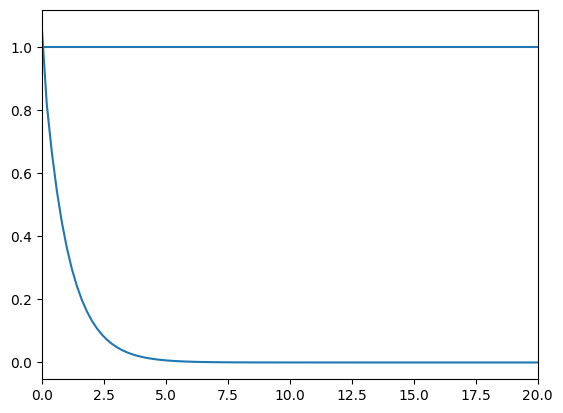

In [15]:
xmin = 0.01
xmax = 1
ys = np.linspace(0.001,20,100)

fs = IntegroPartialDifferentialEquationSolver(xmin,xmax,ys,initial_condition)


# print(len(fs[0]),len(fs[1][0]))
plt.xlim(0,20)
plt.plot(ys,[fs[1][k][3] for k in range(len(ys))])
plt.hlines(y=1,xmin=0,xmax=20)
plt.show()

##### Version 2.0 of the BE solver - with adaptive step-size.

In [ ]:
def BESolver(xmin: float, xmax: float,ys: list,initial_condition):
    fs = [initial_condition(y,xmin) for y in ys]     # define the grid of distribution function values with initial values
    xs = [xmin]                                      # list of x (time) values

    tol = 1e-6      # tolerance
    saf = 1         # safety
    err = 0         # error


    x = xmin
    i = 0       # iterations

    while (x < xmax):
        
        alpha = 0       # define the front factor that are infront of the collision operators

        for k in range(len(ys)):        # looping over all momenta

            # compute the collision integrals
            collision_ann = 0
            collision_sca = 0

            # define the k-factors
            k1 = 0
            k2 = 0  





        dx = min(saf * dx * np.sqrt(tol/abs(err)),2 * dx)   # adapt x (time) step-size
        dx = max(dx, 1e-12)                                 # make sure that the smallest time step x >= 1e-12
    
        x += dx
        xs.append(x)
        i += 1
    
    return (xs, ys, fs)


    